In [1]:
from google.colab import drive
drive.mount('cnontent/')

Mounted at cnontent/


In [3]:
# !pip install -q wandb

In [2]:
import tqdm
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import wandb
# from wandb.keras import WandbCallback
import os
import random
from keras.callbacks import ModelCheckpoint
%matplotlib inline

In [3]:
cd /content/cnontent/MyDrive/SSU/nural_nework/project

/content/cnontent/MyDrive/SSU/nural_nework/project


In [4]:
def convert_data_csv_to_numpy(data, sorting = False): # pandas 통해 읽은 csv data numpy 형태로 변경
  if sorting == True:
    data = data.sort_values(by=[0], axis=0)

  label = np.array(data[0]) # csv file 에서 0번째 colum은 index임
  only_data = np.array(data.drop([0], axis = 1)).reshape((-1, 28, 28, 1)) # csv file에서 0번 째 colum 탈락 -> data만 남게 됨
  # only_data = tf.convert_to_tensor(only_data, dtype=tf.float32)
  return only_data, label

In [5]:
def balanced_data(data, label, border, n_train=1000, val_rate = 0.2):
  i, start=0,0
  d_train = l_train = d_val = l_val= None
  n_data_per_class = n_train
  n_val_per_class = int(n_data_per_class*val_rate)


  for idx, class_end in enumerate(border):
    if i ==0:
      val_end = n_data_per_class+n_val_per_class

      d_train = data[:n_data_per_class].copy()
      l_train = label[:n_data_per_class].copy()

      d_val = data[n_data_per_class:val_end].copy()
      l_val = label[n_data_per_class:val_end].copy()

      i+=1
    else:
      train_end = start+n_data_per_class
      val_end = train_end+n_val_per_class

      now_d_data = data[start:train_end].copy()
      now_l_train = label[start:train_end].copy()
      d_train = np.concatenate((d_train, now_d_data))
      l_train = np.concatenate((l_train, now_l_train))

      now_d_val = data[train_end:val_end].copy()
      now_l_val = label[train_end:val_end].copy()
      d_val = np.concatenate((d_val, now_d_val))
      l_val = np.concatenate((l_val, now_l_val))
    start += class_end
  return (d_train, l_train, d_val, l_val)

In [6]:
train_csv, test_csv = [], []
train_csv = pd.read_csv("./emnist-byclass-train.csv", header=None)

In [7]:
# train, train_label = convert_data_csv_to_numpy(train_csv, sorting = True)
train, train_label = convert_data_csv_to_numpy(train_csv, sorting = False)
train_csv = []

In [8]:
border = np.unique(train_label, return_counts = True)[1]
print(min(border))
print(max(border))

1896
38374


In [9]:
# train_data, train_label, val_data, val_label = balanced_data(train.copy(), train_label, border)
train_data = tf.convert_to_tensor(train, dtype=tf.float32)

In [10]:
# train_data = tf.convert_to_tensor(train_data.copy(), dtype=tf.float32)
# val_data = tf.convert_to_tensor(val_data.copy(), dtype=tf.float32)

boundary = int(train_data.shape[0]*0.8)

final_train = train_data[:boundary]
final_train_label = train_label[:boundary]

final_val = train_data[boundary:]
final_val_label = train_label[boundary:]

In [12]:
type(train_data)

tensorflow.python.framework.ops.EagerTensor

In [11]:
# print(train_data.shape)
# print(train_label.shape)
# print(val_data.shape)
# print(val_label.shape)
print(final_train.shape)
print(final_train_label.shape)
print(final_val.shape)
print(final_val_label.shape)

(558345, 28, 28, 1)
(558345,)
(139587, 28, 28, 1)
(139587,)


In [145]:
# np.save('balanced_train.npy',train_data)
# np.save('balanced_train_label.npy',train_label)
# np.save('balanced_val.npy',val_data)
# np.save('balanced_val_label.npy',val_label)

In [12]:
test_csv = pd.read_csv("./emnist-byclass-test.csv", header=None)
hand_made_csv = pd.read_csv("./our_handmade_dataset.csv", header=None)

In [13]:
test_data, test_label = convert_data_csv_to_numpy(test_csv, sorting = False)
hand_data, hand_label = convert_data_csv_to_numpy(hand_made_csv, sorting = False)

In [14]:
class ResnetBlock(keras.models.Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = keras.layers.Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = keras.layers.BatchNormalization()
        self.conv_2 = keras.layers.Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = keras.layers.BatchNormalization()
        self.merge = keras.layers.Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = keras.layers.Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = keras.layers.BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out

In [15]:
class Res_5x5_v4(keras.models.Model):

    def __init__(self, num_classes, config_list, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.feature_layer_depth, self.num_layer_depth, \
        self.upper_layer_depth, self.lower_layer_depth = config_list

        self.input_ch = 32
        self.layer_ch = 32 * self.feature_layer_depth
        self.Batch_Norm_Layer = keras.layers.BatchNormalization()
        self.Global_Average_Pool_Layer = keras.layers.GlobalAveragePooling2D()
        self.Flatten_Layer = keras.layers.Flatten()

        self.Feature_Detection_Layer = self.feature_detection_layer()

        self.Number_Layer = self.number_layer()
        self.Upper_Letter_Layer = self.upper_letter_layer()
        self.Lower_Letter_Layer = self.lower_letter_layer()


        self.Prediction_Layer = keras.layers.Dense(num_classes, activation="softmax")

    def feature_detection_layer(self):
      feature_dec_layer = keras.models.Sequential()
      feature_dec_layer.add(self.Batch_Norm_Layer)
      feature_dec_layer.add(keras.layers.Conv2D(self.input_ch, (5, 5), strides=1, padding="same", kernel_initializer="he_normal"))
      feature_dec_layer.add(self.Batch_Norm_Layer)
      feature_dec_layer.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=1, padding="same"))
      feature_dec_layer.add(ResnetBlock(self.input_ch))
      feature_dec_layer.add(ResnetBlock(self.input_ch))
      
      for i in range(self.feature_layer_depth-1):
        feature_dec_layer.add(ResnetBlock(self.input_ch*(2*(i+1)), down_sample=True))
        feature_dec_layer.add(ResnetBlock(self.input_ch*(2*(i+1))))


      return feature_dec_layer

    def number_layer(self):
      num_layer = keras.models.Sequential()
      for i in range(self.num_layer_depth):
        num_layer.add(ResnetBlock(self.layer_ch*(2*(i+1)), down_sample=True))
        num_layer.add(ResnetBlock(self.layer_ch*(2*(i+1))))
      num_layer.add(self.Global_Average_Pool_Layer)
      num_layer.add(self.Flatten_Layer)

      return num_layer

    def upper_letter_layer(self):
      upper_layer = keras.models.Sequential()
      for i in range(self.upper_layer_depth):
        upper_layer.add(ResnetBlock(self.layer_ch*(2*(i+1)), down_sample=True))
        upper_layer.add(ResnetBlock(self.layer_ch*(2*(i+1))))
      upper_layer.add(self.Global_Average_Pool_Layer)
      upper_layer.add(self.Flatten_Layer)
      return upper_layer

    def lower_letter_layer(self):
      lower_layer = keras.models.Sequential()

      for i in range(self.lower_layer_depth):
        lower_layer.add(ResnetBlock(self.layer_ch*(2*(i+1)), down_sample=True))
        lower_layer.add(ResnetBlock(self.layer_ch*(2*(i+1))))
      lower_layer.add(self.Global_Average_Pool_Layer)
      lower_layer.add(self.Flatten_Layer)
      return lower_layer

In [16]:
def select_model(config_list):
  model_class = Res_5x5_v4(64, config_list[:-2])
  dense_layer_depth = config_list[-2]
  num_nueran = config_list[-1]

  input = keras.layers.Input(shape=(28, 28, 1))

  feature_out = model_class.Feature_Detection_Layer(input)

  num_out = model_class.Number_Layer(feature_out)
  upper_out = model_class.Upper_Letter_Layer(feature_out)
  lower_out = model_class.Lower_Letter_Layer(feature_out)

  final_out = keras.layers.concatenate([num_out, upper_out, lower_out])
  for i in range(dense_layer_depth):
    final_out = tf.keras.layers.Dense(num_nueran, activation = 'relu')(final_out)

  result = model_class.Prediction_Layer(final_out)

  model = keras.models.Model(inputs=[input], outputs=[result])
  return model

In [17]:
test = [2, 4, 2, 2, 2, 120]

In [18]:
test_model = select_model(test)

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


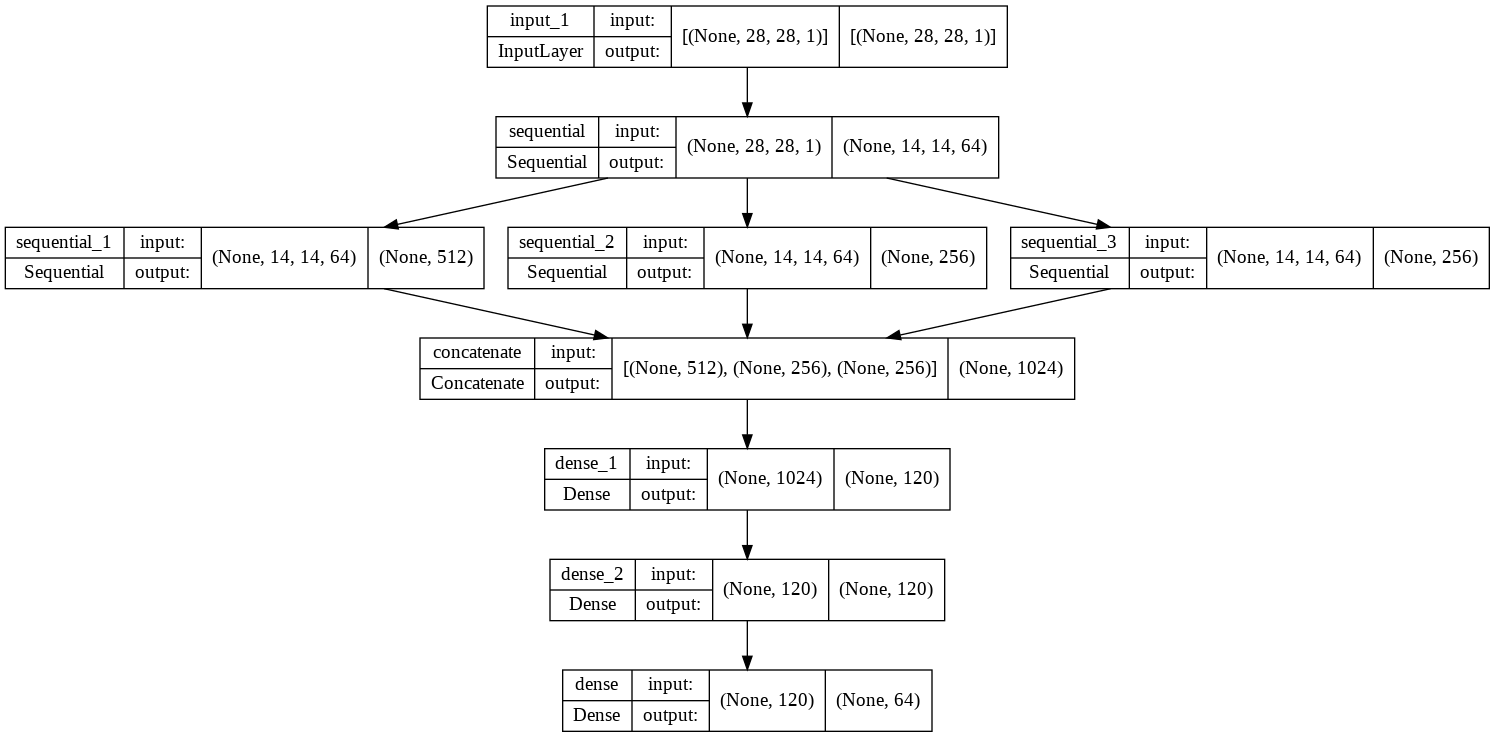

In [19]:
keras.utils.plot_model(test_model, "a.png", show_shapes=True)

In [20]:
test_model.layers[2].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet_block_4 (ResnetBlock  (None, 7, 7, 128)        231296    
 )                                                               
                                                                 
 resnet_block_5 (ResnetBlock  (None, 7, 7, 128)        296192    
 )                                                               
                                                                 
 resnet_block_6 (ResnetBlock  (None, 4, 4, 256)        921344    
 )                                                               
                                                                 
 resnet_block_7 (ResnetBlock  (None, 4, 4, 256)        1182208   
 )                                                               
                                                                 
 resnet_block_8 (ResnetBlock  (None, 2, 2, 384)       

In [21]:
test_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 512)          16661760    ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 256)          2631040     ['sequential[0][0]']             
                                                                                              

In [22]:
model = select_model()

In [133]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential_61 (Sequential)     (None, 7, 7, 128)    698628      ['input_4[0][0]']                
                                                                                                  
 sequential_62 (Sequential)     (None, 256)          2103552     ['sequential_61[0][0]']          
                                                                                                  
 sequential_63 (Sequential)     (None, 256)          3285760     ['sequential_61[0][0]']          
                                                                                            

In [23]:
def select_opt(opt_name, lr):
  if opt_name == 'adam':
    optimizer = keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
  elif opt_name == 'rmsprop':
    optimizer = keras.optimizers.RMSprop(learning_rate=lr, rho=0.9)
  elif opt_name == 'sgd':
    optimizer = keras.optimizers.SGD(learning_rate = lr)
  elif opt_name == 'momentum':
    optimizer = keras.optimizers.SGD(learning_rate = lr, momentum=0.9)
  elif opt_name == 'nesterov':
    optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
  elif opt_name == 'adagrad':
    optimizer = keras.optimizers.Adagrad(learning_rate=lr)
  elif opt_name == 'adamax':
    optimizer = keras.optimizers.Adamax(learning_rate=lr, beta_1=0.9, beta_2=0.999)
  elif opt_name == 'nadam':
    optimizer = keras.optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999)

  return optimizer

In [24]:
def select_activation(function):
  if function == 'relu':
    activation = keras.layers.ReLU()
  elif function == 'prelu':
    activation = keras.layers.PReLU()
  elif function == 'leacky_relu':
    activation = keras.layers.LeakyReLU()
  elif function == 'elu':
    activation = keras.layers.ELU()

  return activation

In [22]:
class LossAndErrorPrintingCallback(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        print(f'''
              epcoh : {epoch}
              loss {logs['loss']}
              accuracy {logs['accuracy']}
              val_loss {logs['val_loss']}
              val_accuracy {logs['val_accuracy']}
              ''')
        wandb.log({'epochs': epoch,
            'loss': logs['loss'],
            'acc': logs['accuracy'], 
            'val_loss': logs['val_loss'],
            'val_acc': logs['val_accuracy']})
        

In [25]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [32]:
def sweep_train(config_defaults=None):
    # Set default values
    config_defaults = {
      'batch_size': 64,
      'optimizer' : 'adam',
      'learning_rate' : 0.01,
      'feature_layer_depth' : 2,
      'num_layer_depth' : 2,
      'upper_layer_depth' : 2,
      'lower_layer_depth' : 2,
      'prediction_layer' : 1,
      'dense_nueran' : 100 
    }
    # Initialize wandb with a sample project name
    wandb.init(config=config_defaults)  # this gets over-written in the Sweep

    # initialize model
    config_list = [wandb.config.feature_layer_depth, wandb.config.num_layer_depth, 
                   wandb.config.upper_layer_depth, wandb.config.lower_layer_depth, wandb.config.prediction_layer, wandb.config.dense_nueran]
    model = select_model(config_list)
    
    print(model.summary())

    # Instantiate an optimizer to train the model.
    optimizer = select_opt(wandb.config.optimizer, wandb.config.learning_rate)


    model.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimizer,
                steps_per_execution=1000,
                metrics=["accuracy"])
    hist = model.fit(train_data, train_label, epochs=50, validation_data=(val_data, val_label), callbacks=[LossAndErrorPrintingCallback(), early_stopping_cb])

In [33]:
sweep_config = {
  'method': 'random', 
  'parameters': {
      
      'optimizer': {
          'values' : ['adam', 'rmsprop', 'sgd', 'momentum', 'nesterov', 'adagrad', 'adamax', 'nadam']
      },
      'learning_rate':{
          'values' : [0.1, 0.05, 0.01, 0.005]
      },
      'feature_layer_depth' : {
          'values' : [1, 2]
      },
      'num_layer_depth' : {
          'values' : [1, 2]
      },
      'upper_layer_depth' : {
          'values' : [1, 2]
      },
      'lower_layer_depth' : {
          'values' : [1, 2]
      },
      'prediction_layer' : {
          'values' : [0, 1]
      },
      'dense_nueran' : {
          'values' : [200, 150, 120, 100]
      }
  }
}

In [134]:
# model.compile(optimizer = "adam",loss='sparse_categorical_crossentropy', metrics=["accuracy"]) 

In [26]:
sweep_id = wandb.sweep(sweep_config, project="res_res")

Create sweep with ID: b8zmrboi
Sweep URL: https://wandb.ai/chanin-eom/res_res/sweeps/b8zmrboi


In [34]:
wandb.agent(sweep_id, function=sweep_train, count=50)

wandb: Agent Starting Run: kf7pc2hr with config:
wandb: 	dense_nueran: 120
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.01
wandb: 	lower_layer_depth: 1
wandb: 	num_layer_depth: 1
wandb: 	optimizer: adagrad
wandb: 	prediction_layer: 0
wandb: 	upper_layer_depth: 2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                              

acc,▁▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
epochs,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_acc,▁▂▅▆▇▇▇▇▇▇▆█▇▇▇▆██▆▇▇▇▇▇▆▇▆▇
val_loss,█▆▃▂▂▂▁▁▁▂▂▁▁▁▁▃▁▁▂▁▂▂▂▂▃▃▃▃
acc,0.92413
epochs,27
loss,0.2238
val_acc,0.7604
val_loss,0.64492


wandb: Agent Starting Run: aq88xuu3 with config:
wandb: 	dense_nueran: 100
wandb: 	feature_layer_depth: 1
wandb: 	learning_rate: 0.01
wandb: 	lower_layer_depth: 1
wandb: 	num_layer_depth: 2
wandb: 	optimizer: nesterov
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 28, 28, 32)   38340       ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          660160      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          660160      ['sequential[0][0]']             
                                                                                              

acc,▁▄▅▅▅▆▆▆▆▆▇▇▇▇▇███
epochs,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
val_acc,▁▃▄▆▆▇▇█▇▆▆▅▇▅▇▇▇▅
val_loss,█▅▄▃▃▂▂▁▃▃▃▄▃▅▄▃▆▆
acc,0.86745
epochs,17
loss,0.3064
val_acc,0.71306
val_loss,0.82234


wandb: Agent Starting Run: cf34hi7q with config:
wandb: 	dense_nueran: 120
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.1
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 2
wandb: 	optimizer: rmsprop
wandb: 	prediction_layer: 0
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 256)          2631040     ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 256)          2631040     ['sequential[0][0]']             
                                                                                              

acc,▁▆▇▇▇▇▇▇██████████████
epochs,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▃▁▅▁▄▁▄▂▂▁▁▄▁▃
val_acc,▄▇▅▇▅▅▆▇▁▄▇▇▇▇▅▃█▅███▇
val_loss,▃▁▂▁▂▂▂▂▃▂▂▁▁▁▅█▁▃▁▂▂▃
acc,0.71074
epochs,21
loss,1.06201
val_acc,0.67355
val_loss,1.4817


wandb: Agent Starting Run: m6rqoy3l with config:
wandb: 	dense_nueran: 120
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.1
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 1
wandb: 	optimizer: nesterov
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                              

acc,▁▅▆▆▆▆▇▇▇▇▇▇▇▇█████
epochs,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▃▆▆▇▇█▇██▇█▇█▇▇▇▆▇
val_loss,█▄▃▂▂▂▁▁▁▂▃▁▃▃▃▄▃▄▇
acc,0.86106
epochs,18
loss,0.31694
val_acc,0.74153
val_loss,0.91677


wandb: Agent Starting Run: 270n5wul with config:
wandb: 	dense_nueran: 100
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.01
wandb: 	lower_layer_depth: 1
wandb: 	num_layer_depth: 1
wandb: 	optimizer: nesterov
wandb: 	prediction_layer: 0
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                              

acc,▁▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██
epochs,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
val_acc,▁▅▆▆█▇█▇█▆██▅▇▇▄▇▆▅
val_loss,▇▃▂▃▂▂▁▁▁▃▂▂▄▃▃▆▄▅█
acc,0.89818
epochs,18
loss,0.24974
val_acc,0.73177
val_loss,0.85856


wandb: Agent Starting Run: hj698px2 with config:
wandb: 	dense_nueran: 100
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.05
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 1
wandb: 	optimizer: rmsprop
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                              

acc,▆▆▄▄▅▆▄█▄▅▇▁▅▃▆▅▅█▇▁▆▅▅▄▆▅▄▅
epochs,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄██▇▄▅▅▆▇▅▆▂▇▄▆▃▅▁▃▅▅▆▅▇▇▄▄▄
acc,0.0159
epochs,27
loss,4.14603
val_acc,0.01613
val_loss,4.14403


wandb: Agent Starting Run: drj3oil7 with config:
wandb: 	dense_nueran: 150
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.01
wandb: 	lower_layer_depth: 1
wandb: 	num_layer_depth: 1
wandb: 	optimizer: sgd
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                              

acc,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████
epochs,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▇▆▇▇▇▇█████▇████▇██▇▇
val_loss,█▃▂▃▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▂
acc,0.84068
epochs,22
loss,0.37863
val_acc,0.73952
val_loss,0.66965


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0d6m3bk0 with config:
wandb: 	dense_nueran: 120
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.01
wandb: 	lower_layer_depth: 1
wandb: 	num_layer_depth: 1
wandb: 	optimizer: adamax
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                              

acc,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇███
epochs,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
val_acc,▁▄▅▆▆▇▇██████▇█▇██
val_loss,█▆▃▂▃▁▂▁▁▂▁▂▂▃▂▃▃▄
acc,0.88231
epochs,17
loss,0.27157
val_acc,0.75315
val_loss,0.81852


wandb: Agent Starting Run: t9efk49m with config:
wandb: 	dense_nueran: 120
wandb: 	feature_layer_depth: 1
wandb: 	learning_rate: 0.05
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 1
wandb: 	optimizer: nadam
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 28, 28, 32)   38340       ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 64)           132672      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 64)           132672      ['sequential[0][0]']             
                                                                                              

acc,▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▅▆▆▇▇▇▇▇▇▇▇▇██████████
epochs,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▇▇▆▆▆▆▆▆▆▆▆▆▆▅▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▂▂▁▂▂▂▂▂▂▂▁▂▅▅▆▆▇▇▇▇▇▆▇▇█▇▇███▇████
val_loss,▇▆▆▆▆▅▆▅▅▅▅▅█▅▃▂▂▂▁▁▁▁▁▃▁▂▁▁▁▁▁▁▂▁▂▁▁
acc,0.60205
epochs,36
loss,1.11466
val_acc,0.56282
val_loss,1.56485


wandb: Agent Starting Run: rz9qvg18 with config:
wandb: 	dense_nueran: 150
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.005
wandb: 	lower_layer_depth: 1
wandb: 	num_layer_depth: 1
wandb: 	optimizer: rmsprop
wandb: 	prediction_layer: 0
wandb: 	upper_layer_depth: 2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                              

acc,▁▄▅▅▆▆▆▆▇▇▇▇██
epochs,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▄▃▃▃▃▂▂▂▂▂▁▁▁
val_acc,▁▅▅▇▅▇█▆▇█▆▆▅▇
val_loss,▇▂▂▁▆▂▁▄▃▃▅█▆▇
acc,0.84527
epochs,13
loss,0.35756
val_acc,0.76089
val_loss,0.77148


wandb: Agent Starting Run: dgvocu28 with config:
wandb: 	dense_nueran: 200
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.1
wandb: 	lower_layer_depth: 1
wandb: 	num_layer_depth: 1
wandb: 	optimizer: adam
wandb: 	prediction_layer: 0
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                              

acc,▁▃▆▆▇▇▇▇▇▇▇▇▇█████████████
epochs,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▅▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▅▆▇▇▇▆▇▇▇▇█▇▇████████▇█▇
val_loss,█▇▃▃▂▂▂▃▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▂▁▂
acc,0.72732
epochs,25
loss,0.63934
val_acc,0.65403
val_loss,1.07865


wandb: Agent Starting Run: wuu358x7 with config:
wandb: 	dense_nueran: 120
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.005
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 1
wandb: 	optimizer: nadam
wandb: 	prediction_layer: 0
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                              

acc,▁▃▃▄▄▄▅▅▅▅▆▆▇▇██
epochs,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▅▅▄▄▄▄▃▃▃▃▂▂▂▁▁
val_acc,▁▂▄▄▆▇▆█▇▇▆▅▅▅▅▆
val_loss,▄▃▂▂▁▁▁▁▂▂▂▃▄▅▆█
acc,0.91987
epochs,15
loss,0.19286
val_acc,0.76008
val_loss,0.91996


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rfst3fvv with config:
wandb: 	dense_nueran: 100
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.005
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 2
wandb: 	optimizer: nadam
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 256)          2631040     ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 256)          2631040     ['sequential[0][0]']             
                                                                                              

acc,▁▄▅▆▆▆▇▇▇▇▇▇███
epochs,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁
val_acc,▁▅▅▆▇▇▇▇▇██████
val_loss,█▃▂▂▁▂▁▂▂▁▁▁▁▂▂
acc,0.81
epochs,14
loss,0.42698
val_acc,0.73879
val_loss,0.86582


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ka7n6hta with config:
wandb: 	dense_nueran: 100
wandb: 	feature_layer_depth: 1
wandb: 	learning_rate: 0.1
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 2
wandb: 	optimizer: momentum
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 28, 28, 32)   38340       ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          660160      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          660160      ['sequential[0][0]']             
                                                                                              

acc,▁▆▆▇▇▇▇▇▇▇▇█████████
epochs,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▆▆▇▇▇▇▇██████████▇█
val_loss,█▂▃▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂
acc,0.84
epochs,19
loss,0.3594
val_acc,0.75145
val_loss,0.71275


wandb: Agent Starting Run: han0rrqt with config:
wandb: 	dense_nueran: 120
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.005
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 2
wandb: 	optimizer: nadam
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 256)          2631040     ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 256)          2631040     ['sequential[0][0]']             
                                                                                              

acc,▁▄▄▅▅▅▆▆▆▆▇▇▇▇██
epochs,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁
val_acc,▁▅▆▆▆▇▇▇▇▇▇██▇▇▇
val_loss,█▃▃▂▂▁▁▁▂▂▂▂▂▃▄▄
acc,0.86173
epochs,15
loss,0.31391
val_acc,0.75669
val_loss,0.74415


wandb: Agent Starting Run: to1j1ekc with config:
wandb: 	dense_nueran: 120
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.005
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 1
wandb: 	optimizer: adamax
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                              

acc,▁▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇██
epochs,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
val_acc,▁▂▄▆▅▄▇▇█▇▇▇▆▅▆▆▆▆▅
val_loss,▄▃▂▁▂▂▁▁▁▁▂▂▂▃▄▄▆▅█
acc,0.93056
epochs,18
loss,0.17099
val_acc,0.74524
val_loss,1.03702


wandb: Agent Starting Run: 8k9i5ylr with config:
wandb: 	dense_nueran: 120
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.05
wandb: 	lower_layer_depth: 1
wandb: 	num_layer_depth: 1
wandb: 	optimizer: adam
wandb: 	prediction_layer: 0
wandb: 	upper_layer_depth: 2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                              

acc,▁▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████
epochs,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▅▆▇▆▆▇▇▇▇█▆██▇█████▇█▇▇▇▇
val_loss,█▃▂▂▂▂▁▁▁▁▁▃▁▁▁▁▁▁▁▁▂▂▂▂▂▃
acc,0.83613
epochs,25
loss,0.36732
val_acc,0.72653
val_loss,0.77179


wandb: Agent Starting Run: iq28cmgb with config:
wandb: 	dense_nueran: 120
wandb: 	feature_layer_depth: 1
wandb: 	learning_rate: 0.01
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 2
wandb: 	optimizer: nadam
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 28, 28, 32)   38340       ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          660160      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          660160      ['sequential[0][0]']             
                                                                                              

acc,▁▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
epochs,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_acc,▁▄▅▅▆▆▇▇▇█▇████▇██▇█
val_loss,█▄▄▃▂▂▁▂▂▁▂▂▁▂▂▃▃▂▄▃
acc,0.84953
epochs,19
loss,0.34683
val_acc,0.75315
val_loss,0.82468


wandb: Agent Starting Run: fmw55zms with config:
wandb: 	dense_nueran: 150
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.01
wandb: 	lower_layer_depth: 1
wandb: 	num_layer_depth: 1
wandb: 	optimizer: adamax
wandb: 	prediction_layer: 0
wandb: 	upper_layer_depth: 2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                              

acc,▁▃▃▄▄▄▄▄▅▅▅▆▆▆▇▇▇███
epochs,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁
val_acc,▁▆▆▇▇█████▇▇▇▇▇▇▇▇▆▇
val_loss,▆▂▂▂▁▁▁▁▁▁▂▃▃▃▄▄▆▆██
acc,0.96334
epochs,19
loss,0.09482
val_acc,0.7604
val_loss,1.12249


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 77fmzhi7 with config:
wandb: 	dense_nueran: 120
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.05
wandb: 	lower_layer_depth: 1
wandb: 	num_layer_depth: 1
wandb: 	optimizer: adamax
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                              

acc,▁▅▆▆▆▆▇▇▇▇▇▇▇▇▇█████
epochs,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▄▆▅▇▇▇▇▇██▇▇███████
val_loss,█▅▃▄▂▁▁▁▂▁▁▃▂▂▂▂▂▂▃▃
acc,0.86168
epochs,19
loss,0.3171
val_acc,0.74919
val_loss,0.79374


wandb: Agent Starting Run: ai1yyb0h with config:
wandb: 	dense_nueran: 200
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.005
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 1
wandb: 	optimizer: nadam
wandb: 	prediction_layer: 0
wandb: 	upper_layer_depth: 2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                              

acc,▁▃▄▄▄▅▅▅▆▆▆▇▇█
epochs,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▅▅▄▄▄▃▃▃▂▂▂▁▁
val_acc,▁▅▆▇▇███▇██▇▇▇
val_loss,█▄▁▁▁▁▁▁▂▂▃▄▆▇
acc,0.89384
epochs,13
loss,0.24983
val_acc,0.76492
val_loss,0.77053


wandb: Agent Starting Run: n8lxlaws with config:
wandb: 	dense_nueran: 200
wandb: 	feature_layer_depth: 1
wandb: 	learning_rate: 0.1
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 2
wandb: 	optimizer: nadam
wandb: 	prediction_layer: 0
wandb: 	upper_layer_depth: 2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 28, 28, 32)   38340       ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          660160      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          660160      ['sequential[0][0]']             
                                                                                              

acc,▁▅▆▆▆▇▇▇▇▇▇▇██████
epochs,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▃▆▅▇▄▇▇▇▆▆▆█▇▇▇██
val_loss,█▅▂▃▁▄▁▁▂▂▂▁▁▁▁▁▁▁
acc,0.76974
epochs,17
loss,0.52224
val_acc,0.74815
val_loss,0.68372


wandb: Agent Starting Run: 4ff07eo1 with config:
wandb: 	dense_nueran: 120
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.01
wandb: 	lower_layer_depth: 1
wandb: 	num_layer_depth: 1
wandb: 	optimizer: sgd
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                              

acc,▁▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████
epochs,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▇▇▇▇▇▇█▇▇██▇▇███▇▇▇▇█▇▇▇
val_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▂▂▂▁▂▂▂
acc,0.86187
epochs,25
loss,0.33357
val_acc,0.75016
val_loss,0.68541


wandb: Agent Starting Run: kak74qnv with config:
wandb: 	dense_nueran: 150
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.05
wandb: 	lower_layer_depth: 1
wandb: 	num_layer_depth: 2
wandb: 	optimizer: adagrad
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 256)          2631040     ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 256)          2631040     ['sequential[0][0]']             
                                                                                              

acc,▁▄▅▅▅▆▆▆▆▇▇▇▇███
epochs,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val_acc,▃▇▆▆▇███▇▇▁▇▇▇▇▇
val_loss,▃▁▁▁▁▁▁▁▂▂█▃▃▃▄▄
acc,0.91855
epochs,15
loss,0.19806
val_acc,0.74339
val_loss,0.87325


wandb: Agent Starting Run: zvt79yjx with config:
wandb: 	dense_nueran: 100
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.05
wandb: 	lower_layer_depth: 1
wandb: 	num_layer_depth: 1
wandb: 	optimizer: momentum
wandb: 	prediction_layer: 0
wandb: 	upper_layer_depth: 2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                              

acc,▁▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
epochs,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
val_acc,▁▃▄▆▇▇▆██▆▇▄▆▆▅▄▅▃
val_loss,▅▃▃▂▂▁▂▁▁▂▂▄▃▄▅▆▆█
acc,0.89494
epochs,17
loss,0.24879
val_acc,0.73274
val_loss,0.83125


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: viuy9sw0 with config:
wandb: 	dense_nueran: 150
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.1
wandb: 	lower_layer_depth: 1
wandb: 	num_layer_depth: 1
wandb: 	optimizer: adamax
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                              

acc,▁▆▆▆▇▇▇▇▇▇▇▇▇███████
epochs,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▄▁▆▇▇▇▇█▇███▇█▇████▆
val_loss,▃█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
acc,0.80892
epochs,19
loss,0.42442
val_acc,0.68339
val_loss,0.83976


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tqgp2xip with config:
wandb: 	dense_nueran: 100
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.1
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 1
wandb: 	optimizer: nadam
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                              

acc,█▃▅▁▄▅▆▃▅▅▄▃▅▃▃▅▂▄▅▂▃▃▆▆▄▂▅
epochs,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▄▄▄▄▃▄▁▂█▆▄▅▆▄▃▁▃▃▅▆▂▃▂▆▇▆
acc,0.01626
epochs,26
loss,4.15965
val_acc,0.01613
val_loss,4.16306


wandb: Agent Starting Run: f46orofr with config:
wandb: 	dense_nueran: 120
wandb: 	feature_layer_depth: 1
wandb: 	learning_rate: 0.05
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 2
wandb: 	optimizer: adamax
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 28, 28, 32)   38340       ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          660160      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          660160      ['sequential[0][0]']             
                                                                                              

acc,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇██████
epochs,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▆▇▇▇▇▇████▇██████▇██
val_loss,█▃▂▂▂▁▂▁▁▁▁▃▂▂▂▂▂▂▂▃▂
acc,0.86805
epochs,20
loss,0.3027
val_acc,0.74847
val_loss,0.76688


wandb: Agent Starting Run: 3ikpuf4s with config:
wandb: 	dense_nueran: 200
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.01
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 1
wandb: 	optimizer: adagrad
wandb: 	prediction_layer: 0
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                              

acc,▁▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
epochs,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_acc,▁▃▄▆▅▆▆▆▆▇▇▇█▇▆▇▆▇▆▆▆▇▆
val_loss,█▅▄▃▃▂▂▂▂▂▂▂▁▂▂▁▂▂▂▂▃▂▃
acc,0.89024
epochs,22
loss,0.28951
val_acc,0.76879
val_loss,0.57827


wandb: Agent Starting Run: 9t4u5g9q with config:
wandb: 	dense_nueran: 200
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.05
wandb: 	lower_layer_depth: 1
wandb: 	num_layer_depth: 2
wandb: 	optimizer: adamax
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 256)          2631040     ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 256)          2631040     ['sequential[0][0]']             
                                                                                              

acc,▁▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
epochs,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▅▃▆▇▇▇▇██████▇█████
val_loss,█▃▅▂▁▂▂▂▂▁▂▂▂▁▂▃▃▃▃▃
acc,0.86371
epochs,19
loss,0.30951
val_acc,0.75161
val_loss,0.80445


wandb: Agent Starting Run: in78sphe with config:
wandb: 	dense_nueran: 150
wandb: 	feature_layer_depth: 1
wandb: 	learning_rate: 0.1
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 1
wandb: 	optimizer: adamax
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 28, 28, 32)   38340       ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 64)           132672      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 64)           132672      ['sequential[0][0]']             
                                                                                              

acc,▁▄▆▆▆▇▇▇▇▇▇▇▇██████████████
epochs,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▆▆▇▇▇▇██▇███████████████▇
val_loss,██▃▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
acc,0.78398
epochs,26
loss,0.48394
val_acc,0.64169
val_loss,0.95653


wandb: Agent Starting Run: i6jtt897 with config:
wandb: 	dense_nueran: 150
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.01
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 2
wandb: 	optimizer: adagrad
wandb: 	prediction_layer: 0
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 256)          2631040     ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 256)          2631040     ['sequential[0][0]']             
                                                                                              

acc,▁▃▄▄▅▅▆▆▇▇▇█████
epochs,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
val_acc,▁▅█▆▇█▇█▇▇▆▇▇▇▇█
val_loss,▆▂▁▂▁▁▂▂▃▃▅▆▆▇██
acc,0.98935
epochs,15
loss,0.04207
val_acc,0.76371
val_loss,0.83873


wandb: Agent Starting Run: foj7ms6z with config:
wandb: 	dense_nueran: 120
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.05
wandb: 	lower_layer_depth: 1
wandb: 	num_layer_depth: 1
wandb: 	optimizer: adam
wandb: 	prediction_layer: 0
wandb: 	upper_layer_depth: 2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                              

acc,▁▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████
epochs,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▅▅▅▄▅▇▆▇▇▄██▇▅▇▇█▇███
val_loss,█▄▄▃▃▅▂▂▁▃▄▁▁▂▄▂▃▂▄▃▃▄
acc,0.81905
epochs,21
loss,0.40634
val_acc,0.75274
val_loss,0.72405


wandb: Agent Starting Run: 4bs3zhxg with config:
wandb: 	dense_nueran: 150
wandb: 	feature_layer_depth: 1
wandb: 	learning_rate: 0.05
wandb: 	lower_layer_depth: 1
wandb: 	num_layer_depth: 1
wandb: 	optimizer: adamax
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 28, 28, 32)   38340       ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 64)           132672      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 64)           132672      ['sequential[0][0]']             
                                                                                              

acc,▁▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████
epochs,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▄▆▆▆▆▇▇▇▇██▇█████████▇███
val_loss,█▃▄▃▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▂▂▁▂▂▂▂
acc,0.83158
epochs,26
loss,0.37821
val_acc,0.75323
val_loss,0.72147


wandb: Agent Starting Run: f0vgsxik with config:
wandb: 	dense_nueran: 100
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.1
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 1
wandb: 	optimizer: nadam
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                              

acc,▆▆█▆▁▅▂▁▅▃▅
epochs,▁▂▂▃▄▅▅▆▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▃▂▃▅▁▄▁▃▄█
acc,0.01595
epochs,10
loss,4.15994
val_acc,0.01613
val_loss,4.17462


wandb: Agent Starting Run: xuzy3qqg with config:
wandb: 	dense_nueran: 200
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.1
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 2
wandb: 	optimizer: sgd
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 256)          2631040     ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 256)          2631040     ['sequential[0][0]']             
                                                                                              

acc,▁▄▅▅▆▆▆▆▇▇▇▇██
epochs,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁
val_acc,▁▂▄▆▆▆▆▆▇▅▆█▇▅
val_loss,█▇▃▁▁▂▂▂▃▄▄▃▇█
acc,0.86805
epochs,13
loss,0.30086
val_acc,0.73048
val_loss,0.83007


wandb: Agent Starting Run: 3bzo65b2 with config:
wandb: 	dense_nueran: 100
wandb: 	feature_layer_depth: 1
wandb: 	learning_rate: 0.005
wandb: 	lower_layer_depth: 1
wandb: 	num_layer_depth: 2
wandb: 	optimizer: nadam
wandb: 	prediction_layer: 0
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 28, 28, 32)   38340       ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          660160      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          660160      ['sequential[0][0]']             
                                                                                              

acc,▁▃▃▄▄▄▅▅▅▆▆▆▇▇██
epochs,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▅▅▄▄▄▄▃▃▃▃▂▂▂▁▁
val_acc,▁▆▄█▇██▇▇███▇█▇▇
val_loss,█▂▃▁▁▁▁▁▁▁▁▂▃▃▅▅
acc,0.90439
epochs,15
loss,0.22561
val_acc,0.75726
val_loss,0.81686


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 68p2ey97 with config:
wandb: 	dense_nueran: 100
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.1
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 2
wandb: 	optimizer: adamax
wandb: 	prediction_layer: 0
wandb: 	upper_layer_depth: 2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 256)          2631040     ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 256)          2631040     ['sequential[0][0]']             
                                                                                              

acc,▁▅▅▆▆▆▆▇▇▇▇▇▇▇████
epochs,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_acc,▁▅▆▆▇▇▇█▇███▇▇▇██▇
val_loss,█▄▃▂▂▂▁▁▄▁▁▂▄▃▃▃▃▃
acc,0.86434
epochs,17
loss,0.30741
val_acc,0.74556
val_loss,0.73407


wandb: Agent Starting Run: o692zff7 with config:
wandb: 	dense_nueran: 100
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.005
wandb: 	lower_layer_depth: 1
wandb: 	num_layer_depth: 2
wandb: 	optimizer: adamax
wandb: 	prediction_layer: 0
wandb: 	upper_layer_depth: 2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 256)          2631040     ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 256)          2631040     ['sequential[0][0]']             
                                                                                              

acc,▁▃▃▄▄▄▄▅▅▆▆▆▇▇███
epochs,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▆▅▅▄▄▄▃▃▃▃▂▂▂▁▁▁
val_acc,▁▄▆▆▇▇█▇▇▇▇▇▇▇▇▆▆
val_loss,▄▂▁▂▁▁▁▂▂▂▂▃▄▆▇██
acc,0.96984
epochs,16
loss,0.07984
val_acc,0.75766
val_loss,1.1175


wandb: Agent Starting Run: sofr9ymg with config:
wandb: 	dense_nueran: 100
wandb: 	feature_layer_depth: 1
wandb: 	learning_rate: 0.005
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 1
wandb: 	optimizer: rmsprop
wandb: 	prediction_layer: 0
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 28, 28, 32)   38340       ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 64)           132672      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 64)           132672      ['sequential[0][0]']             
                                                                                              

acc,▁▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████
epochs,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_acc,▁▄▅▆▆▆▆▇▇▇█▇▆▇██▇▇▇▇█▇▇▇█▇█▇▇▇▆
val_loss,█▅▃▂▂▂▂▂▂▂▁▁▂▂▁▁▂▄▂▂▁▁▂▃▂▃▂▃▃▃▆
acc,0.85447
epochs,30
loss,0.33454
val_acc,0.72726
val_loss,1.00698


wandb: Agent Starting Run: 0so3zf7e with config:
wandb: 	dense_nueran: 100
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.005
wandb: 	lower_layer_depth: 1
wandb: 	num_layer_depth: 1
wandb: 	optimizer: sgd
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                              

acc,▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epochs,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▆▆▇▇▇▇████████████████████████
val_loss,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.84215
epochs,31
loss,0.3845
val_acc,0.75637
val_loss,0.60818


wandb: Agent Starting Run: wlimf39e with config:
wandb: 	dense_nueran: 100
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.005
wandb: 	lower_layer_depth: 1
wandb: 	num_layer_depth: 1
wandb: 	optimizer: sgd
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                              

acc,▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
epochs,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▄▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▆▆▇▇▇▇▇▇█▇▇█████████████████▇███
val_loss,█▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.84721
epochs,33
loss,0.37342
val_acc,0.75581
val_loss,0.62145


wandb: Agent Starting Run: go3h0o9k with config:
wandb: 	dense_nueran: 120
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.05
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 1
wandb: 	optimizer: momentum
wandb: 	prediction_layer: 0
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          527488      ['sequential[0][0]']             
                                                                                              

acc,▁▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
epochs,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
val_acc,▁▅▆▅▅▅▅█▆▇█▅▃▆▆▅▃▄
val_loss,▅▂▁▂▂▂▃▁▂▁▂▃█▃▄▄█▇
acc,0.89877
epochs,17
loss,0.24117
val_acc,0.7371
val_loss,0.87303


wandb: Agent Starting Run: 4x0p3uya with config:
wandb: 	dense_nueran: 200
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.05
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 2
wandb: 	optimizer: nadam
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 256)          2631040     ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 256)          2631040     ['sequential[0][0]']             
                                                                                              

acc,▄▂▂▃▄▂▁▆▄▃▄▅▃▅█▇▃▆▁▄▂▅▃▄▂▄▃▅▃▄▇
epochs,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▆▃▃▅▂▄▄▄▅▂▄▇▃▃▄▂█▂▆▁▃▃▄▅▂▃▂▅▅▅
acc,0.01671
epochs,30
loss,4.14339
val_acc,0.01613
val_loss,4.14672


wandb: Agent Starting Run: cow3wrq9 with config:
wandb: 	dense_nueran: 150
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.1
wandb: 	lower_layer_depth: 1
wandb: 	num_layer_depth: 2
wandb: 	optimizer: nesterov
wandb: 	prediction_layer: 0
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 256)          2631040     ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 256)          2631040     ['sequential[0][0]']             
                                                                                              

acc,▁▄▅▅▅▆▆▆▆▆▆▇▇▇▇███
epochs,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
val_acc,▁▃▅▃▇▇▆█▇█▇▇█▇▆▆▇▆
val_loss,▇▄▃▅▂▂▂▁▂▂▂▃▂▅▇▅▆█
acc,0.91585
epochs,17
loss,0.20392
val_acc,0.73774
val_loss,0.8569


wandb: Agent Starting Run: o7kdjnuk with config:
wandb: 	dense_nueran: 200
wandb: 	feature_layer_depth: 1
wandb: 	learning_rate: 0.05
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 2
wandb: 	optimizer: adamax
wandb: 	prediction_layer: 0
wandb: 	upper_layer_depth: 2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 28, 28, 32)   38340       ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          660160      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          660160      ['sequential[0][0]']             
                                                                                              

acc,▁▄▅▅▆▆▆▆▇▇▇▇▇██
epochs,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁
val_acc,▁▂▅▇▇▆▇▆█▇▇█▇▇▇
val_loss,█▆▃▁▁▂▁▁▁▁▂▂▂▂▄
acc,0.86192
epochs,14
loss,0.31386
val_acc,0.7625
val_loss,0.66946


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q3ibd8wt with config:
wandb: 	dense_nueran: 120
wandb: 	feature_layer_depth: 1
wandb: 	learning_rate: 0.01
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 2
wandb: 	optimizer: nadam
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 28, 28, 32)   38340       ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          660160      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 128)          660160      ['sequential[0][0]']             
                                                                                              

acc,▁▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epochs,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
val_acc,▁▃▅▆▆▇▇▇▇▇█▇▇███▇█▇▇▇
val_loss,█▆▄▃▂▁▁▁▂▂▁▁▂▁▂▃▄▂▆▅▅
acc,0.86485
epochs,20
loss,0.31449
val_acc,0.7404
val_loss,0.87003


wandb: Agent Starting Run: 4shfbml9 with config:
wandb: 	dense_nueran: 120
wandb: 	feature_layer_depth: 2
wandb: 	learning_rate: 0.01
wandb: 	lower_layer_depth: 2
wandb: 	num_layer_depth: 2
wandb: 	optimizer: adamax
wandb: 	prediction_layer: 0
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 14, 14, 64)   171012      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 256)          2631040     ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 256)          2631040     ['sequential[0][0]']             
                                                                                              

acc,▁▃▃▄▄▄▅▅▅▅▆▆▇▇▇███
epochs,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▅▅▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
val_acc,▁▃▆▆▇▇█████▇▇▇▇▇▇▇
val_loss,▄▃▂▂▁▁▁▁▁▁▂▂▃▄▅▅▆█
acc,0.96339
epochs,17
loss,0.09389
val_acc,0.75476
val_loss,1.23131


wandb: Agent Starting Run: mco42bls with config:
wandb: 	dense_nueran: 100
wandb: 	feature_layer_depth: 1
wandb: 	learning_rate: 0.05
wandb: 	lower_layer_depth: 1
wandb: 	num_layer_depth: 1
wandb: 	optimizer: nadam
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 28, 28, 32)   38340       ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 64)           132672      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 64)           132672      ['sequential[0][0]']             
                                                                                              

acc,▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
epochs,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▅▃▆▆▆▇▇▇▆▇▁▇███████████████▇█▇█▇
val_loss,▂▂▂▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.71535
epochs,32
loss,0.67885
val_acc,0.645
val_loss,1.13782


wandb: Agent Starting Run: od661c86 with config:
wandb: 	dense_nueran: 100
wandb: 	feature_layer_depth: 1
wandb: 	learning_rate: 0.1
wandb: 	lower_layer_depth: 1
wandb: 	num_layer_depth: 1
wandb: 	optimizer: adamax
wandb: 	prediction_layer: 1
wandb: 	upper_layer_depth: 2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 28, 28, 32)   38340       ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 64)           132672      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 64)           132672      ['sequential[0][0]']             
                                                                                              

acc,▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
epochs,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▅▆▆▆▆▇▇▇▇▇▇▇███▇▇▇███████
val_loss,█▅▄▃▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁
acc,0.77537
epochs,26
loss,0.51669
val_acc,0.7196
val_loss,0.76612


In [192]:
test_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential_98 (Sequential)     (None, 14, 14, 64)   171012      ['input_11[0][0]']               
                                                                                                  
 sequential_99 (Sequential)     (None, 256)          2631040     ['sequential_98[0][0]']          
                                                                                                  
 sequential_100 (Sequential)    (None, 256)          2631040     ['sequential_98[0][0]']          
                                                                                            

In [149]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential_61 (Sequential)     (None, 7, 7, 128)    698628      ['input_4[0][0]']                
                                                                                                  
 sequential_62 (Sequential)     (None, 256)          2103552     ['sequential_61[0][0]']          
                                                                                                  
 sequential_63 (Sequential)     (None, 256)          3285760     ['sequential_61[0][0]']          
                                                                                            

In [126]:
type(val_label)

numpy.ndarray

In [142]:
history = model.fit(train_data, train_label, epochs = 50, validation_data=(val_data, val_label))

Epoch 1/50
1938/1938 [==============================] - 51s 24ms/step - loss: 0.9882 - accuracy: 0.6548 - val_loss: 0.9882 - val_accuracy: 0.6442
Epoch 2/50
1938/1938 [==============================] - 46s 24ms/step - loss: 0.6721 - accuracy: 0.7237 - val_loss: 0.7210 - val_accuracy: 0.7085
Epoch 3/50
1938/1938 [==============================] - 46s 24ms/step - loss: 0.6029 - accuracy: 0.7458 - val_loss: 0.6374 - val_accuracy: 0.7425
Epoch 4/50
1938/1938 [==============================] - 46s 24ms/step - loss: 0.5551 - accuracy: 0.7610 - val_loss: 0.6167 - val_accuracy: 0.7419
Epoch 5/50
1938/1938 [==============================] - 46s 24ms/step - loss: 0.5151 - accuracy: 0.7736 - val_loss: 0.5698 - val_accuracy: 0.7665
Epoch 6/50
1938/1938 [==============================] - 46s 24ms/step - loss: 0.4797 - accuracy: 0.7895 - val_loss: 0.5930 - val_accuracy: 0.7601
Epoch 7/50
1938/1938 [==============================] - 46s 24ms/step - loss: 0.4493 - accuracy: 0.7986 - val_loss: 0.5829 -

In [25]:
# self.feature_layer_depth, self.num_layer_depth, self.upper_layer_depth, self.lower_layer_depth = config_list
# dense_layer_depth = config_list[-2]
# num_nueran = config_list[-1]
model1_list = [2, 1, 2, 1, 0, 200]
model2_list = [2, 1, 2, 2, 0, 200]
model3_list = [1, 2, 2, 2, 0, 200]
model4_list = [2, 2, 2, 1, 0, 150]

In [26]:
first_model = select_model(model1_list)
second_model = select_model(model2_list)
third_model = select_model(model3_list)
fourth_model = select_model(model4_list)

first_model.summary()
second_model.summary()
third_model.summary()
fourth_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential_4 (Sequential)      (None, 14, 14, 64)   171012      ['input_2[0][0]']                
                                                                                                  
 sequential_5 (Sequential)      (None, 128)          527488      ['sequential_4[0][0]']           
                                                                                                  
 sequential_6 (Sequential)      (None, 256)          2631040     ['sequential_4[0][0]']           
                                                                                            

In [27]:
print(final_train.shape)
print(final_train_label.shape)
print(final_val.shape)
print(final_val_label.shape)

(558345, 28, 28, 1)
(558345,)
(139587, 28, 28, 1)
(139587,)


In [68]:
class LossAndErrorPrintingCallback(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        print(
            f'''
            epcoh : {epoch}
            loss {logs['loss']}
            accuracy {logs['accuracy']}
            val_loss {logs['val_loss']}
            val_accuracy {logs['val_accuracy']}
            ''')
        fourth_model.save_weights('fourth_weight{}'.format(epoch))


In [35]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("resres_2_1_2_1_0_200.h5", save_best_only=True)

learning_rate = 0.01
opt = select_opt('adagrad', learning_rate)
print(opt)
first_model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
first_history = first_model.fit(final_train, final_train_label, epochs=50, validation_data=(final_val, final_val_label), callbacks=[early_stopping_cb, LossAndErrorPrintingCallback()])

Epoch 1/50
17449/17449 [==============================] - ETA: 0s - loss: 0.4690 - accuracy: 0.8402
            epcoh : 0
            loss 0.46897751092910767
            accuracy 0.8401955962181091
            val_loss 0.3703801929950714
            val_accuracy 0.8645145893096924
            
17449/17449 [==============================] - 345s 20ms/step - loss: 0.4690 - accuracy: 0.8402 - val_loss: 0.3704 - val_accuracy: 0.8645
Epoch 2/50
17446/17449 [============================>.] - ETA: 0s - loss: 0.3555 - accuracy: 0.8681
            epcoh : 1
            loss 0.35548362135887146
            accuracy 0.8680546879768372
            val_loss 0.3571421205997467
            val_accuracy 0.8670793175697327
            
17449/17449 [==============================] - 342s 20ms/step - loss: 0.3555 - accuracy: 0.8681 - val_loss: 0.3571 - val_accuracy: 0.8671
Epoch 3/50
17446/17449 [============================>.] - ETA: 0s - loss: 0.3327 - accuracy: 0.8746
            epcoh : 2
          

In [59]:
test_model = select_model(model1_list)
test_model.compile(loss="sparse_categorical_crossentropy", optimizer='adagrad', metrics=["accuracy"])
test_model.load_weights('test_weight_7')

In [60]:
test_model.evaluate(test_data, test_label)
first_model.evaluate(test_data, test_label)

3636/3636 [==============================] - 26s 7ms/step - loss: 0.3335 - accuracy: 0.8747


[0.333548367023468, 0.8747453093528748]

In [51]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("resres_2_1_2_2_0_200.h5", save_best_only=True)

learning_rate = 0.005
opt = select_opt('nadam', learning_rate)
print(opt)
second_model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
second_history = second_model.fit(final_train, final_train_label, epochs=50, validation_data=(final_val, final_val_label), callbacks=[early_stopping_cb, LossAndErrorPrintingCallback()])

Epoch 1/50
17449/17449 [==============================] - ETA: 0s - loss: 0.4565 - accuracy: 0.8400
            epcoh : 0
            loss 0.4565375745296478
            accuracy 0.8399502038955688
            val_loss 0.39258500933647156
            val_accuracy 0.8570855259895325
            
17449/17449 [==============================] - 609s 34ms/step - loss: 0.4565 - accuracy: 0.8400 - val_loss: 0.3926 - val_accuracy: 0.8571
Epoch 2/50
17449/17449 [==============================] - ETA: 0s - loss: 0.3615 - accuracy: 0.8657
            epcoh : 1
            loss 0.36149677634239197
            accuracy 0.8657102584838867
            val_loss 0.3829265534877777
            val_accuracy 0.8542342782020569
            
17449/17449 [==============================] - 599s 34ms/step - loss: 0.3615 - accuracy: 0.8657 - val_loss: 0.3829 - val_accuracy: 0.8542
Epoch 3/50
17449/17449 [==============================] - ETA: 0s - loss: 0.3392 - accuracy: 0.8719
            epcoh : 2
          

In [61]:
test_model_2 = select_model(model2_list)
test_model_2.load_weights('second_weight5')
test_model_2.compile(loss="sparse_categorical_crossentropy", optimizer='nadam', metrics=["accuracy"])

In [62]:
test_model_2.evaluate(test_data, test_label)
second_model.evaluate(test_data, test_label)

3636/3636 [==============================] - 32s 9ms/step - loss: 0.3350 - accuracy: 0.8743


[0.334963858127594, 0.8743155002593994]

In [64]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("resres_1_2_2_2_0_200.h5", save_best_only=True)

learning_rate = 0.05
opt = select_opt('adamax', learning_rate)
print(opt)
third_model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
third_history = third_model.fit(final_train, final_train_label, epochs=50, validation_data=(final_val, final_val_label), callbacks=[early_stopping_cb, LossAndErrorPrintingCallback()])

Epoch 1/50
17448/17449 [============================>.] - ETA: 0s - loss: 0.5104 - accuracy: 0.8252
            epcoh : 0
            loss 0.5103855133056641
            accuracy 0.8251743912696838
            val_loss 0.4065193235874176
            val_accuracy 0.8535393476486206
            
17449/17449 [==============================] - 425s 24ms/step - loss: 0.5104 - accuracy: 0.8252 - val_loss: 0.4065 - val_accuracy: 0.8535
Epoch 2/50
17449/17449 [==============================] - ETA: 0s - loss: 0.3733 - accuracy: 0.8621
            epcoh : 1
            loss 0.3733178675174713
            accuracy 0.8620566129684448
            val_loss 0.3781042993068695
            val_accuracy 0.8629958629608154
            
17449/17449 [==============================] - 416s 24ms/step - loss: 0.3733 - accuracy: 0.8621 - val_loss: 0.3781 - val_accuracy: 0.8630
Epoch 3/50
17447/17449 [============================>.] - ETA: 0s - loss: 0.3527 - accuracy: 0.8687
            epcoh : 2
            

In [66]:
test_model_3 = select_model(model3_list)
test_model_3.load_weights('third_weight8')
test_model_3.compile(loss="sparse_categorical_crossentropy", optimizer='adamax', metrics=["accuracy"])

In [67]:
test_model_3.evaluate(test_data, test_label)
third_model.evaluate(test_data, test_label)

3636/3636 [==============================] - 28s 7ms/step - loss: 0.3388 - accuracy: 0.8736


[0.3388412892818451, 0.8735847473144531]

In [69]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("resres_2_2_2_1_0_150.h5", save_best_only=True)

learning_rate = 0.01
opt = select_opt('adagrad', learning_rate)
print(opt)
fourth_model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
fourth_history = fourth_model.fit(final_train, final_train_label, epochs=50, validation_data=(final_val, final_val_label), callbacks=[early_stopping_cb, LossAndErrorPrintingCallback()])

Epoch 1/50
17447/17449 [============================>.] - ETA: 0s - loss: 0.4659 - accuracy: 0.8402
            epcoh : 0
            loss 0.46586930751800537
            accuracy 0.8402457237243652
            val_loss 0.3732331097126007
            val_accuracy 0.8645647764205933
            
17449/17449 [==============================] - 401s 23ms/step - loss: 0.4659 - accuracy: 0.8402 - val_loss: 0.3732 - val_accuracy: 0.8646
Epoch 2/50
17448/17449 [============================>.] - ETA: 0s - loss: 0.3533 - accuracy: 0.8683
            epcoh : 1
            loss 0.35327261686325073
            accuracy 0.8683305382728577
            val_loss 0.34877052903175354
            val_accuracy 0.8701311945915222
            
17449/17449 [==============================] - 397s 23ms/step - loss: 0.3533 - accuracy: 0.8683 - val_loss: 0.3488 - val_accuracy: 0.8701
Epoch 3/50
17449/17449 [==============================] - ETA: 0s - loss: 0.3287 - accuracy: 0.8753
            epcoh : 2
         

In [70]:
test_model_4 = select_model(model4_list)
test_model_4.load_weights('fourth_weight5')
test_model_4.compile(loss="sparse_categorical_crossentropy", optimizer='adagrad', metrics=["accuracy"])

In [71]:
test_model_4.evaluate(test_data, test_label)
fourth_model.evaluate(test_data, test_label)

3636/3636 [==============================] - 30s 8ms/step - loss: 0.3345 - accuracy: 0.8736


[0.3344658315181732, 0.8736449480056763]